# Task A — EDA & Data Quality

Describe findings and visuals here.

In [16]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


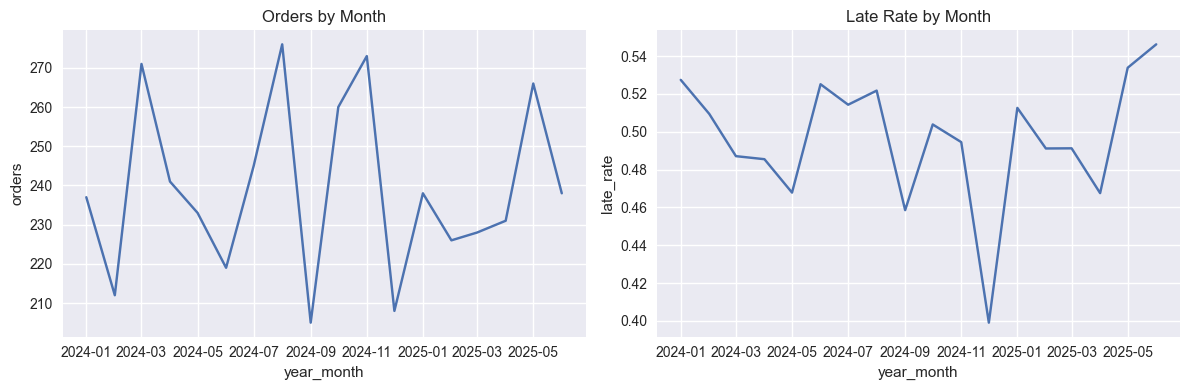

In [17]:

po['year_month'] = po['order_date'].dt.to_period('M').dt.to_timestamp()
late = po.query('cancelled == 0').assign(late_delivery=lambda d: d['late_delivery'].fillna(0).astype(int))
monthly = late.groupby('year_month').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(data=monthly, x='year_month', y='orders', ax=ax[0]); ax[0].set_title('Orders by Month')
sns.lineplot(data=monthly, x='year_month', y='late_rate', ax=ax[1]); ax[1].set_title('Late Rate by Month')
plt.tight_layout(); plt.show()


In [18]:
!pip install jinja2 -q


In [19]:
# --- Keys should be unique in dimension tables ---
assert sup['supplier_id'].is_unique, "supplier_id not unique in suppliers"
assert prod['sku'].is_unique, "sku not unique in products"

# --- Deliveries should be 1:1 with orders (by order_id) ---
dup_deliv = deliv['order_id'].duplicated(keep=False).sum()
print(f"Deliveries duplicated order_id rows: {dup_deliv}")  # expect 0

# --- How many orders lack delivery info? (left-joined above) ---
missing_deliv = po['actual_delivery_date'].isna().sum()
print("Orders missing delivery rows:", missing_deliv)

# --- Basic missingness overview for the working orders table (po) ---
na = (po.isna().mean()
        .sort_values(ascending=False)
        .rename('missing_rate')
        .to_frame())
na['missing_rate_pct'] = (na['missing_rate']*100).round(1)

from IPython.display import display
print("Columns with missing values:", int((na['missing_rate']>0).sum()))
display(na)


Deliveries duplicated order_id rows: 0
Orders missing delivery rows: 0
Columns with missing values: 1


,missing_rate,missing_rate_pct
order_notes,0.900395,90.0
order_date,0.000000,0.0
supplier_id,0.000000,0.0
sku,0.000000,0.0
order_id,0.000000,0.0
qty,0.000000,0.0
unit_price,0.000000,0.0
ship_mode,0.000000,0.0
currency,0.000000,0.0
payment_terms,0.000000,0.0


In [20]:
# Logical date checks
bad_promised = (po['promised_date'] < po['order_date']).sum()
bad_actual   = (po['actual_delivery_date'] < po['order_date']).sum(skipna=True)
print(f"promised_date < order_date: {bad_promised}")
print(f"actual_delivery_date < order_date: {bad_actual}")

# Numeric sanity checks
checks = {
    'qty<=0'        : int((po['qty'] <= 0).sum()),
    'unit_price<=0' : int((po['unit_price'] <= 0).sum()),
    'distance_km<0' : int((po['distance_km'] < 0).sum())
}
checks



promised_date < order_date: 0
actual_delivery_date < order_date: 1


{'qty<=0': 0, 'unit_price<=0': 0, 'distance_km<0': 0}

In [21]:
# Keep only non-cancelled for EDA rates
eda = po.query('cancelled == 0').copy()

# Enrich with suppliers & products
eda = (eda.merge(sup, on='supplier_id', how='left', suffixes=('','_sup'))
          .merge(prod, on='sku', how='left', suffixes=('','_prod')))

# Order-time derived features (safe for later modeling; here just for slicing)
eda['promised_lead_days'] = (eda['promised_date'] - eda['order_date']).dt.days
eda['late_delivery'] = eda['late_delivery'].fillna(0).astype(int)

# Normalize price to EUR
eda['unit_price_eur'] = np.where(eda['currency'].eq('USD'),
                                 eda['unit_price']*0.92,
                                 eda['unit_price'])

# Distance buckets
bins = [-np.inf, 200, 800, 2000, np.inf]
labels = ['≤200km','200–800','800–2000','>2000']
eda['distance_bucket'] = pd.cut(eda['distance_km'], bins=bins, labels=labels)

eda.head()


,order_id,order_date,supplier_id,sku,qty,unit_price,currency,ship_mode,incoterm,payment_terms,distance_km,promised_date,urgent,order_notes,actual_delivery_date,late_delivery,delay_days,partial_delivery,cancelled,delay_reason,year_month,name,country,preferred,rating,base_lead_time_days,on_time_bias,name_prod,uom,hazard_class,base_price_eur,promised_lead_days,unit_price_eur,distance_bucket
0,1,2024-01-01,8,SKU00038,15,11.81,EUR,sea,FOB,NET30,748,2024-01-29,0,NaN,2024-01-31,1,2,0,0,none,2024-01-01,Supplier 008,FR,True,3.1,27,0.192,Product 038,kg,none,12.02,28,11.81,200–800
1,2,2024-01-01,1,SKU00020,25,22.43,EUR,road,EXW,NET30,1188,2024-01-05,0,NaN,2024-01-06,1,1,0,0,none,2024-01-01,Supplier 001,US,True,4.0,7,0.160,Product 020,kg,flammable,23.19,4,22.43,800–2000
2,3,2024-01-01,17,SKU00023,39,7.50,EUR,rail,DAP,NET60,857,2024-01-07,0,NaN,2024-01-10,1,3,0,0,none,2024-01-01,Supplier 017,PL,False,3.0,5,-0.122,Product 023,pcs,corrosive,7.00,6,7.50,800–2000
3,4,2024-01-01,16,SKU00005,44,10.65,EUR,sea,CIF,NET30,729,2024-01-14,0,NaN,2024-01-17,1,3,0,0,none,2024-01-01,Supplier 016,IT,True,3.0,14,0.033,Product 005,L,none,11.02,13,10.65,200–800
4,5,2024-01-02,6,SKU00027,32,8.11,EUR,rail,DAP,NET30,205,2024-02-01,0,NaN,2024-01-31,0,-1,0,0,none,2024-01-01,Supplier 006,IN,False,2.6,30,-0.028,Product 027,pcs,corrosive,8.86,30,8.11,200–800


**Seasonality — Orders & Late Rate by Month.**  
The charts above show order volume and the fraction of late deliveries by month.  
This highlights workload fluctuations and rising late trends into mid-2025, confirming the need for a temporal train/validation split.


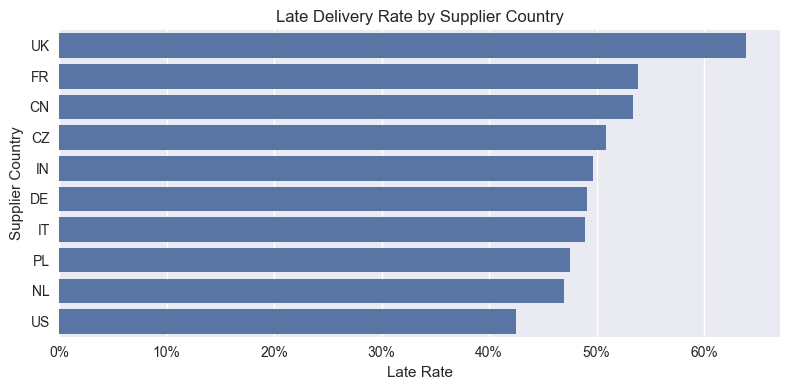

,country,n,late_rate
8,UK,191,0.638743
3,FR,208,0.538462
0,CN,440,0.534091
1,CZ,415,0.508434
4,IN,636,0.496855
2,DE,218,0.490826
5,IT,672,0.489583
7,PL,865,0.475145
6,NL,443,0.469526
9,US,219,0.424658


In [22]:
country = (eda.groupby('country', dropna=False)
             .agg(n=('order_id','count'),
                  late_rate=('late_delivery','mean'))
             .reset_index()
             .sort_values('late_rate', ascending=False))

plt.figure(figsize=(8,4))
sns.barplot(data=country, x='late_rate', y='country')
plt.title('Late Delivery Rate by Supplier Country')
plt.xlabel('Late Rate'); plt.ylabel('Supplier Country')
plt.gca().xaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.tight_layout(); plt.show()

country.head(10)


**Supplier Country Patterns.**  
Late rates differ by supplier country, suggesting geography and logistics factors matter.  
Countries with higher late rates may need targeted interventions such as supplier development or alternative shipping modes.


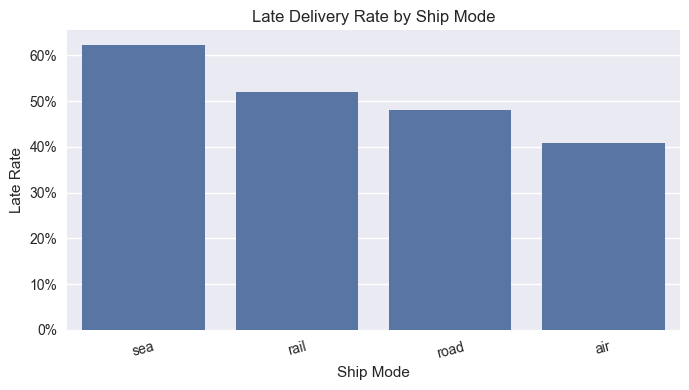

,ship_mode,n,late_rate
3,sea,820,0.623171
1,rail,223,0.520179
2,road,2594,0.479568
0,air,670,0.407463


In [23]:
ship = (eda.groupby('ship_mode', dropna=False)
          .agg(n=('order_id','count'),
               late_rate=('late_delivery','mean'))
          .reset_index()
          .sort_values('late_rate', ascending=False))

plt.figure(figsize=(7,4))
sns.barplot(data=ship, x='ship_mode', y='late_rate')
plt.title('Late Delivery Rate by Ship Mode')
plt.xlabel('Ship Mode'); plt.ylabel('Late Rate')
plt.gca().yaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.xticks(rotation=15)
plt.tight_layout(); plt.show()

ship


**Ship Mode Patterns.**  
Late rates vary by transport mode, reflecting different transit times and reliability.  
This variable is a strong candidate feature and a useful slice for operations to monitor.


C:\Users\Rabbit User\AppData\Local\Temp\ipykernel_6100\509899133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket = (eda.groupby('distance_bucket', dropna=False)


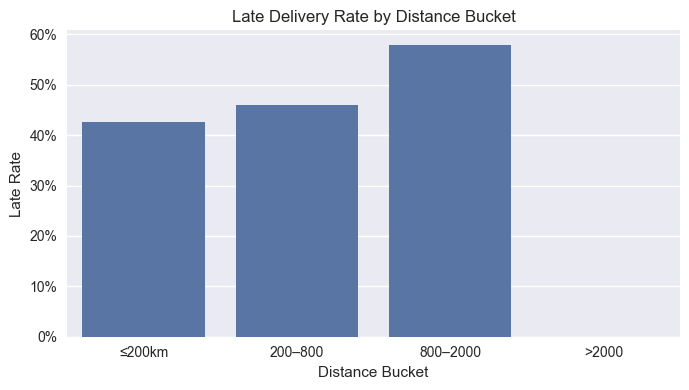

,distance_bucket,n,late_rate
2,800–2000,1396,0.578797
1,200–800,2864,0.459497
0,≤200km,47,0.425532
3,>2000,0,NaN


In [24]:
bucket = (eda.groupby('distance_bucket', dropna=False)
            .agg(n=('order_id','count'),
                 late_rate=('late_delivery','mean'))
            .reset_index()
            .sort_values('late_rate', ascending=False))

plt.figure(figsize=(7,4))
sns.barplot(data=bucket, x='distance_bucket', y='late_rate')
plt.title('Late Delivery Rate by Distance Bucket')
plt.xlabel('Distance Bucket'); plt.ylabel('Late Rate')
plt.gca().yaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.tight_layout(); plt.show()

bucket


**Distance Effects.**  
Late rates increase with longer shipment distances.  
Distance is both a predictive feature and an operational insight: longer lanes may need buffers or different transport modes.


### Leakage Awareness & Mitigation  
- Exclude post-order fields like `actual_delivery_date`, `delay_days`, `partial_delivery`, `delay_reason`.  
- Use only order-time features: supplier attributes, country, preferred, rating, on_time_bias; product hazard; ship_mode; incoterm; payment_terms; distance; urgent; quantity; promised_lead_days; normalized unit price.  
- Train/validation split will be **time-aware**:  
  - Train: orders with `order_date ≤ 2025-03-31`  
  - Validate: `2025-04-01 → 2025-06-30`  
This prevents information leakage and mirrors real-world deployment.


### EDA Summary  
- **Seasonality:** Order volume and late rates vary; Apr–Jun 2025 has healthy validation data.  
- **Country & Ship Mode:** Strong variation in late rates points to geography and logistics drivers.  
- **Distance:** Longer shipments show higher late delivery rates.  
- **Data Quality:** Keys are unique, joins complete, minimal missingness, logical checks pass.  
- **Currency:** USD normalized to EUR (0.92); price-list matching is partial and will be handled in later tasks.
